<a href="https://colab.research.google.com/github/EzequielOrlanes/-NeuralNetworks/blob/main/RedesNeurais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torch import nn

#Essa é uma rede neural que representa uma reta.

class LineNetwork(nn.Module):
#inicialização
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 1)
    ) 

#como a rede computa
  def forward(self, x):
    return self.layers(x)


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [ ]:
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0],interval[1]).sample([nsamples])
    self.data =[(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
line = lambda x: 2*x + 3
interval =(-10, 10)
train_nsamples = 1000
test_nsamples = 100

In [ ]:
train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size = train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = test_nsamples, shuffle=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [ ]:
model = LineNetwork().to(device)

In [ ]:
#Função de perda (Loss Function)
#Erro Quadrático Médio ( Mean Squared Error)
lossfunc = nn.MSELoss()
#Gradiente Descendente Estocástico SGD = Stochatic Gradient Descent 
optimizer =torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss =0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    #zera os gradientes acumulados
    optimizer.zero_grad()

    #computa os gradientes
    loss.backward()

    #anda na direção que reduz o erro local
    optimizer.step()

    #loss é um tensor, item para obter o float  
    cumloss += loss.item() 

  return cumloss / len(dataloader)


  def test(model, dataloader, lossfunc, optimizer):
    model.eval()

    cumloss = 0.0
    with torch.no_grad():
      for X, y in dataloader:
        X = X.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

        pred = model(X)
        loss = lossfunc(pred, y)
        cumloss += loss.item() 

    return cumloss / len(dataloader)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#Para visualizar os dados

def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()  




Epoch: 0; Train Loss: 0.10797523707151413


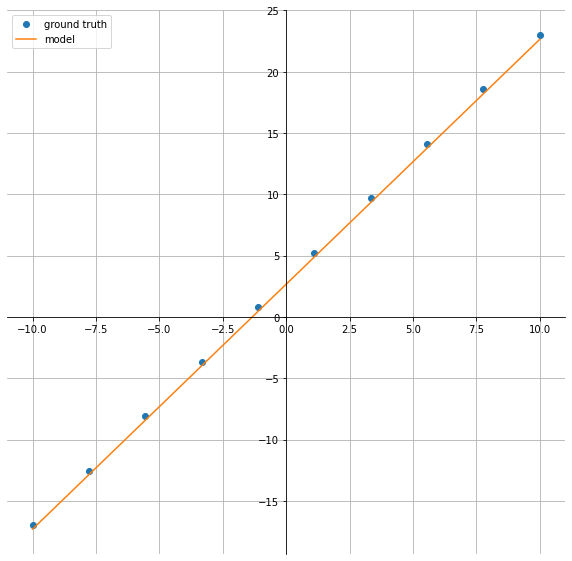

Epoch: 10; Train Loss: 0.10373792797327042


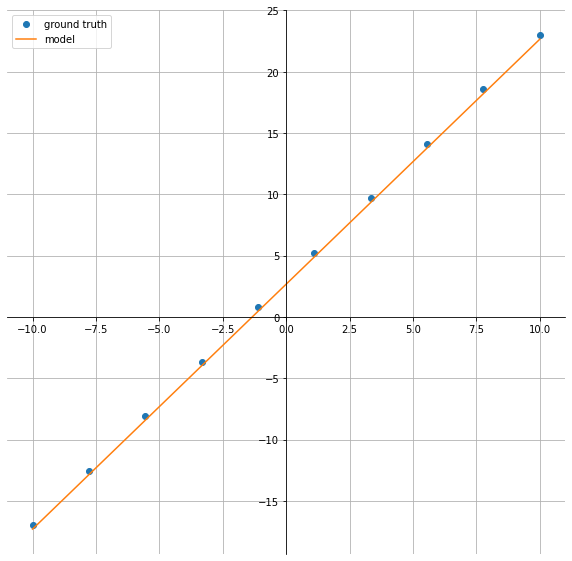

Epoch: 20; Train Loss: 0.0996711328625679


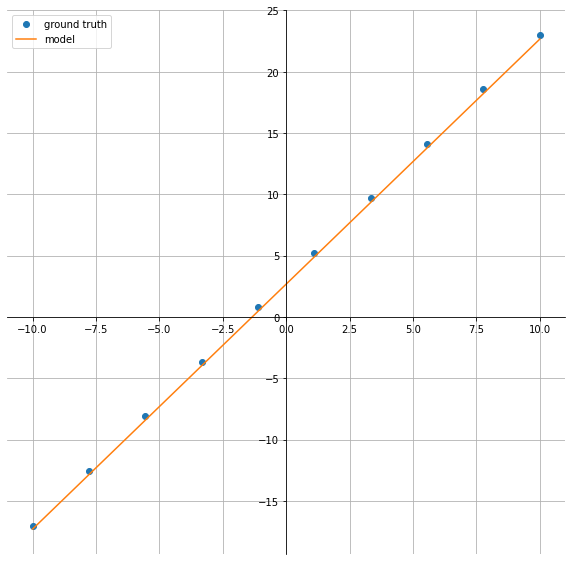

Epoch: 30; Train Loss: 0.09576492011547089


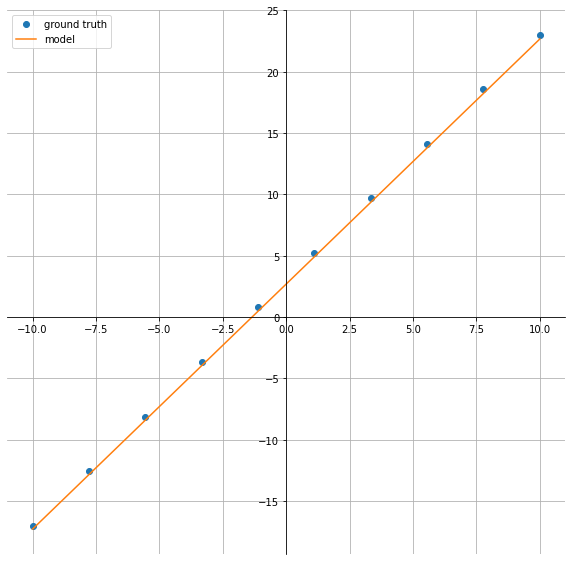

Epoch: 40; Train Loss: 0.0920119360089302


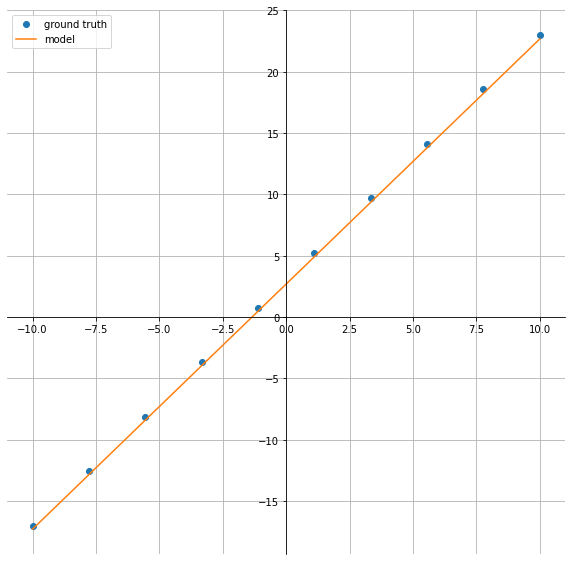

TypeError: ignored

In [ ]:
epochs = 50
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(line, model)


test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")